In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.covariance import EmpiricalCovariance, EllipticEnvelope
from sklearn.metrics import normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, plot_precision_recall_curve, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
import datetime, time

In [ ]:
fire_df = pd.read_csv("dataset_new.csv")

In [ ]:
fire_df = fire_df.drop(columns=['pres','paramId_0'])

In [ ]:
fire_df = fire_df.astype({'time': 'datetime64[ns]'})

In [ ]:
temp_df = fire_df.drop(columns=['latitude','longitude','paramId_0'])

In [ ]:
fire_df['DOY'] = fire_df['time'].dt.dayofyear
fire_df['Year'] = fire_df['time'].dt.year
fire_df = fire_df.groupby(['DOY','latitude','longitude','Year'], as_index=False).mean()
fire_df['longitude'] = fire_df['longitude'] - 360
fire_df['latitude'] = pd.cut(fire_df['latitude'], bins=np.arange(17, 71, 0.5).tolist())
fire_df['longitude'] = pd.cut(fire_df['longitude'], bins=np.arange(-179, -64, 0.5).tolist())
fires = pd.read_csv('/Users/macbook/Documents/SML/Project/Fires.csv')
fires['LATITUDE'] = pd.cut(fires['LATITUDE'], bins=np.arange(17, 71, 0.5).tolist())
fires['LONGITUDE'] = pd.cut(fires['LONGITUDE'], bins=np.arange(-179, -64, 0.5).tolist())
fires['fire'] = 1
fires = fires.drop_duplicates()
Xy = pd.merge(fire_df, fires, how='left', 
         left_on=['DOY','latitude','longitude','Year'], 
         right_on=['DISCOVERY_DOY','LATITUDE','LONGITUDE','FIRE_YEAR']).drop(columns = ['DISCOVERY_DOY','LATITUDE','LONGITUDE','FIRE_YEAR'])

Xy['fire'] = Xy['fire'].fillna(0)

In [ ]:
fire_class = Xy["fire"]
fire_features = Xy.drop(columns=['fire','latitude','longitude'])

In [ ]:
feature_train = fire_features[fire_features["Year"] < 2009]
feature_test = fire_features[fire_features["Year"] >= 2009]

target_train = fire_class[fire_features["Year"] < 2009]
target_test = fire_class[fire_features["Year"] >= 2009] 

Checked with some Anomaly detection algorithms, didn't work

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('iso', IsolationForest())])
target_train_pred = pipe.fit_predict(feature_train)
target_train_pred[target_train_pred==1] = 0
target_train_pred[target_train_pred==-1] = 1
normalized_mutual_info_score(target_train, target_train_pred)

0.007208316793123187

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lof', LocalOutlierFactor(n_neighbors=10))])
target_train_pred = pipe.fit_predict(feature_train)
target_train_pred[target_train_pred==1] = 0
target_train_pred[target_train_pred==-1] = 1
normalized_mutual_info_score(target_train, target_train_pred)

0.0002454427013110006

Classifiers:
1. Logistic Reg

In [ ]:
pipe_log = Pipeline([('poly', PolynomialFeatures(3)),
                     ('scaler', RobustScaler()),
                     ('log', LogisticRegression(class_weight = "balanced", max_iter=700))])
pipe_log.fit(feature_train, target_train)

# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(pipe_log.score(feature_train, 
                                                       target_train), 4))
print("Testa set accuracy:", np.round(pipe_log.score(feature_test, target_test),
                                     4))

# Precision and Recall of the Training Set
target_pred_train_log = pipe_log.predict(feature_train)
print("Training Set Precision:", np.round(precision_score(target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = pipe_log.predict(feature_test)
print("Test Set Precision:", np.round(precision_score(target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(target_test, 
                                                    target_pred_test_log), 4))

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training set accuracy: 0.5905
Test set accuracy: 0.5742
Training Set Precision: 0.0653
Training Set Recall: 0.798
Training Set F1 Score: 0.1207
Test Set Precision: 0.0516
Test Set Recall: 0.8112
Test Set F1 Score: 0.097


Using only 10 day dataset, and filtering out the redundant parameters:

In [3]:
tenday_df = pd.read_csv("bestgeo_sametime_10day.csv")

In [4]:
tenday_df['fire'].value_counts()

0    147611
1     28684
Name: fire, dtype: int64

In [8]:
tenday_df = pd.read_csv("bestgeo_sametime_5day.csv")

In [15]:
tenday_df = pd.read_csv("bestgeo_sametime_3day.csv")

In [ ]:
tenday_df

In [ ]:
tenday_df['latitude'] = pd.qcut(tenday_df['latitude'], 15, labels=False)
tenday_df['longitude'] = pd.qcut(tenday_df['longitude'], 15, labels=False)

In [16]:
tenday_features_full = tenday_df.drop(columns=["index_3day", "latitude", "longitude",
                                               "('time', 'first')","('time', 'last')",
                                               "('Year', 'last')","('paramId_0', 'amin')",
                                               "('paramId_0', 'amax')","('paramId_0', 'mean')",
                                               "('paramId_0', 'var')","('month', '<lambda>')",
                                               "('macro_season', '<lambda>')",
                                               "('DOY', 'last')","fire"])
tenday_target = tenday_df['fire']

tenday_full_train = tenday_features_full[tenday_df.iloc[:,7] < 2009]
tenday_full_test = tenday_features_full[tenday_df.iloc[:,7] >= 2009]

tenday_target_train = tenday_target[tenday_df.iloc[:,7] < 2009]
tenday_target_test = tenday_target[tenday_df.iloc[:,7] >= 2009]

In [ ]:
tenday_target_test.value_counts()

0    30276
1     4983
Name: fire, dtype: int64

In [ ]:
tenday_full_train.head()

,"('DOY', 'first')","('Year', 'first')","('cwat', 'amin')","('cwat', 'amax')","('cwat', 'mean')","('cwat', 'var')","('r', 'amin')","('r', 'amax')","('r', 'mean')","('r', 'var')","('tozne', 'amin')","('tozne', 'amax')","('tozne', 'mean')","('tozne', 'var')","('gh', 'amin')","('gh', 'amax')","('gh', 'mean')","('gh', 'var')","('pwat', 'amin')","('pwat', 'amax')","('pwat', 'mean')","('pwat', 'var')","('pres', 'amin')","('pres', 'amax')","('pres', 'mean')","('pres', 'var')","('pres', 'count')",fire
0,1,2001,0.0,0.42,0.10325,0.009705,8.0,48.0,21.625,124.189103,263.500000,304.299988,275.714999,55.564852,1996.160034,4595.839844,3437.303995,375561.694036,6.0,28.500000,13.6700,37.680100,34430.0,34430.0,34430.000000,NaN,1,0
1,11,2001,0.0,0.22,0.07200,0.005263,10.0,35.0,23.425,35.789103,270.799988,360.100006,299.162502,499.005931,1412.479980,3907.840088,3023.840012,392217.477221,7.1,18.299999,13.1850,7.657718,61430.0,62960.0,62443.333333,7.702333e+05,3,0
2,21,2001,0.0,0.43,0.05825,0.007605,13.0,55.0,27.250,77.935897,244.000000,334.700012,294.970002,687.441196,1434.560059,3530.560059,2666.500000,428711.746884,7.8,22.600000,14.3550,16.905103,65030.0,75960.0,71433.333333,3.250763e+07,3,0
3,31,2001,0.0,0.32,0.03575,0.005051,7.0,29.0,17.275,34.871154,264.399994,348.000000,308.012503,724.518117,1338.880005,3921.919922,3329.412003,368061.030616,4.7,20.100000,11.1450,14.892795,NaN,NaN,NaN,NaN,0,0
4,41,2001,0.0,0.69,0.11475,0.025159,18.0,50.0,27.250,39.987179,278.700012,407.299988,334.750002,1495.393708,1112.160034,3168.800049,2183.276001,400916.670683,10.3,28.000000,15.1125,15.711378,41470.0,76180.0,57815.000000,2.113109e+08,10,0


SVM, Ensemble and Boosting Classifiers:

In [ ]:
clf_log_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('log', LogisticRegression(class_weight = "balanced", max_iter=10000))])
clf_log_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_log_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_log_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_log_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_log_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.6986
Test set accuracy: 0.6828
Training Set Precision: 0.3322
Training Set Recall: 0.7857
Training Set F1 Score: 0.467
Test Set Precision: 0.2785
Test Set Recall: 0.7823
Test Set F1 Score: 0.4107


In [ ]:
clf_svc_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('scaler', StandardScaler()),
                               ('svm', SVC())])
clf_svc_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_svc_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_svc_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_svc_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_svc_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.8338
Test set accuracy: 0.8588
Training Set Precision: 0.7369
Training Set Recall: 0.0167
Training Set F1 Score: 0.0326
Test Set Precision: 0.5246
Test Set Recall: 0.0064
Test Set F1 Score: 0.0127


In [ ]:
clf_ext_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('svm', GradientBoostingClassifier())])
clf_ext_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_ext_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_ext_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_ext_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_ext_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.8429
Test set accuracy: 0.859
Training Set Precision: 0.6548
Training Set Recall: 0.1376
Training Set F1 Score: 0.2274
Test Set Precision: 0.5038
Test Set Recall: 0.171
Test Set F1 Score: 0.2553


In [ ]:
clf_rf_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('rf', RandomForestClassifier())])
clf_rf_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_rf_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_rf_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_rf_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_rf_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 1.0
Test set accuracy: 0.8541
Training Set Precision: 1.0
Training Set Recall: 0.9999
Training Set F1 Score: 0.9999
Test Set Precision: 0.4649
Test Set Recall: 0.2125
Test Set F1 Score: 0.2917


In [ ]:
clf_adb_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('adb', AdaBoostClassifier())])
clf_adb_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_adb_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_adb_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_adb_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_adb_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.8324
Test set accuracy: 0.8523
Training Set Precision: 0.5046
Training Set Recall: 0.1329
Training Set F1 Score: 0.2104
Test Set Precision: 0.4333
Test Set Recall: 0.1473
Test Set F1 Score: 0.2199


In [ ]:
clf_gbc_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('gbc', GradientBoostingClassifier())])
clf_gbc_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_gbc_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_gbc_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_gbc_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_gbc_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.8429
Test set accuracy: 0.8588
Training Set Precision: 0.6548
Training Set Recall: 0.1376
Training Set F1 Score: 0.2274
Test Set Precision: 0.5015
Test Set Recall: 0.1714
Test Set F1 Score: 0.2555


In [ ]:
clf_xgb_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('poly', PolynomialFeatures(2)),
                               ('scaler', StandardScaler()),
                               ('xgb', XGBClassifier())])
clf_xgb_10day_full.fit(tenday_full_train, tenday_target_train)

In [ ]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_xgb_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_xgb_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_xgb_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_xgb_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.8394
Test set accuracy: 0.8617
Training Set Precision: 0.6735
Training Set Recall: 0.086
Training Set F1 Score: 0.1525
Test Set Precision: 0.5455
Test Set Recall: 0.1286
Test Set F1 Score: 0.2082


The best classifier found:

In [12]:
clf_log

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [17]:
clf_xgb_10day_full = Pipeline([('imp', SimpleImputer(strategy = "mean")),
                               ('scaler', StandardScaler()),
                               ('xgb', clf_log)])
clf_xgb_10day_full.fit(tenday_full_train, tenday_target_train)

Pipeline(memory=None,
         steps=[('imp',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgb',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
# Accuracies of Training and Test Set 
print("Training set accuracy:", np.round(clf_vc_10day_full.score(tenday_full_train, 
                                                       tenday_target_train), 4))
print("Test set accuracy:", np.round(clf_vc_10day_full.score(tenday_full_test,
                                                        tenday_target_test), 4))

# Precision and Recall of the Training Set
target_pred_train_log = clf_vc_10day_full.predict(tenday_full_train)
print("Training Set Precision:", np.round(precision_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set Recall:", np.round(recall_score(tenday_target_train, 
                                                    target_pred_train_log), 4))
print("Training Set F1 Score:", np.round(f1_score(tenday_target_train, 
                                                    target_pred_train_log), 4))

# Precision and Recall of the Test Set
target_pred_test_log = clf_vc_10day_full.predict(tenday_full_test)
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Training set accuracy: 0.6811
Test set accuracy: 0.6783
Training Set Precision: 0.1542
Training Set Recall: 0.6325
Training Set F1 Score: 0.2479
Test Set Precision: 0.1296
Test Set Recall: 0.6439
Test Set F1 Score: 0.2157


In [ ]:
Training set accuracy: 0.8875
Test set accuracy: 0.8018
Training Set Precision: 0.6123
Training Set Recall: 0.9012
Training Set F1 Score: 0.7292
Test Set Precision: 0.3932
Test Set Recall: 0.7409
Test Set F1 Score: 0.5138
Test Set Precision: 0.202
Test Set Recall: 0.988
Test Set F1 Score: 0.3355

Training set accuracy: 0.8738
Test set accuracy: 0.7852
Training Set Precision: 0.5821
Training Set Recall: 0.883
Training Set F1 Score: 0.7016
Test Set Precision: 0.3682
Test Set Recall: 0.7267
Test Set F1 Score: 0.4888
Test Set Precision: 0.1905
Test Set Recall: 0.9896
Test Set F1 Score: 0.3195

Training set accuracy: 0.859
Test set accuracy: 0.7614
Training Set Precision: 0.5513
Training Set Recall: 0.8648
Training Set F1 Score: 0.6734
Test Set Precision: 0.3275
Test Set Recall: 0.653
Test Set F1 Score: 0.4362

In [ ]:
tenday_target_test.value_counts()

0    30276
1     4983
Name: fire, dtype: int64

In [ ]:
target_pred_test_log = clf_vc_10day_full.predict(tenday_full_test)

print("Confusion Matrix with default 0.5 threshold: \n", np.round(confusion_matrix(tenday_target_test, 
                                                      target_pred_test_log), 4))

Confusion Matrix with default 0.5 threshold: 
 [[24579  5697]
 [ 1291  3692]]


In [ ]:
y_scores = clf_vc_10day_full.predict_proba(tenday_full_test)
target_pred_test_log = (clf_vc_10day_full.predict_proba(tenday_full_test)[:,1] >= 0.1).astype(bool)

print("Confusion Matrix when recall set to high: \n", np.round(confusion_matrix(tenday_target_test, 
                                                      target_pred_test_log), 4))

Confusion Matrix when recall set to high: 
 [[10833 19443]
 [   60  4923]]


In [ ]:
print("Test Set Precision:", np.round(precision_score(tenday_target_test, 
                                                      target_pred_test_log), 4))
print("Test Set Recall:", np.round(recall_score(tenday_target_test, 
                                                target_pred_test_log), 4))
print("Test Set F1 Score:", np.round(f1_score(tenday_target_test, 
                                                    target_pred_test_log), 4))

Test Set Precision: 0.202
Test Set Recall: 0.988
Test Set F1 Score: 0.3355


In [ ]:
precision_scores, recall_scores, thresholds = precision_recall_curve(tenday_target_test, np.max(y_scores, 1))

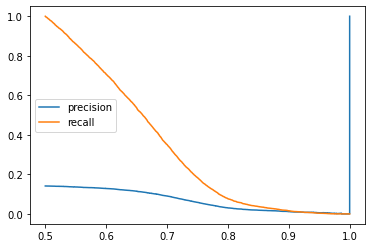

In [ ]:
plt.plot(thresholds, precision_scores[1:], label="precision")
plt.plot(thresholds, recall_scores[1:], label="recall")
plt.legend()
plt.show()

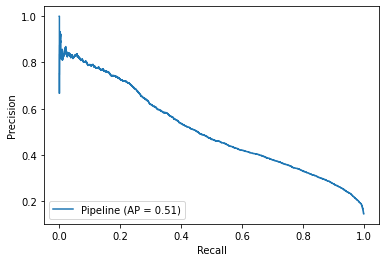

In [ ]:
plot_precision_recall_curve(clf_vc_10day_full, tenday_full_test, tenday_target_test)

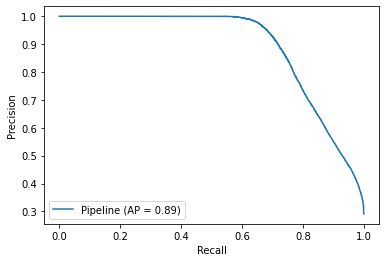

In [ ]:
plot_precision_recall_curve(clf_vc_10day_full, tenday_full_train, tenday_target_train)